In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch
import random

SEARCH_SPACE = {
    'k_size_a': [1, 3, 5],
    'k_size_b': [1, 3, 5],
    'out_channels_a': [8, 16, 32, 64],
    'out_channels_b': [8, 16, 32, 64],
    'include_pool_a': [True, False],
    'include_pool_b': [True, False],
    'pool_type_a': ['max_pooling','avg_pooling'],
    'pool_type_b': ['max_pooling','avg_pooling'],
    'activation_type_a': ['relu', 'tanh', 'elu', 'selu'],
    'activation_type_b': ['relu', 'tanh', 'elu', 'selu'], 
    'include_b': [True, False],
    'include_BN_a': [True, False],
    'include_BN_b': [True, False],
    'skip_connection': [True, False],
}

class FinalModel(nn.Module):
    def __init__(self, chromosome):
        super().__init__()
        self.block = chromosome.model
        if chromosome.phase == 0:
            in_channels = 3
            out_channels = chromosome.genes['out_channels_b']
        else:
            if(chromosome.prev_best.genes['include_b']):
                in_channels = chromosome.prev_best.genes['out_channels_b']
            else:
                in_channels = chromosome.prev_best.genes['out_channels_a']
            if(chromosome.genes['include_b']):
                out_channels = chromosome.genes['out_channels_b']
            else:
                out_channels = chromosome.genes['out_channels_a']
        self.skip = nn.Conv2d(in_channels, out_channels, 1)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(out_channels*chromosome.out_dimensions**2,10)

    def forward(self, x, chromosome):
        if chromosome.genes['skip_connection']:
            y = x
            if chromosome.phase != 0:
                y = chromosome.prev_best.model(x)
            y = self.skip(y)
        x=self.block(x)
        if chromosome.genes['skip_connection']:
            x = x + y
        x = self.fc(self.flatten(x))
        x = F.log_softmax(x, dim=1)
        return x


class Chromosome:
    def __init__(self,phase:int,prev_best,genes:dict,train_loader,test_loader):
        self.phase = phase
        self.prev_best = prev_best
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.genes = genes
        self.out_dimensions = prev_best.out_dimensions if phase!=0 else 32
        self.fitness = -1 
        self.model:nn.Module = self.build_model()
        self.train_loader = train_loader
        self.test_loader = test_loader
        if self.fitness==-1:
            self.fitness = self.fitness_function(train_loader,test_loader)

    def build_model(self)->nn.Module:
        if(self.prev_best!=None):
            prev_best_model:nn.Module = self.prev_best.model
        new_model_modules = []
        padding_size = 0
        if(self.genes['skip_connection']):
            padding_size = 16 if self.phase==0 else self.prev_best.out_dimensions//2
        if(self.out_dimensions<self.genes['k_size_a']):
            self.fitness = 0
            return nn.Sequential()
        
        if(self.phase!=0):
            # layer_a = nn.Conv2d(self.prev_best.genes['out_channels_b'] if self.prev_best.genes['include_b'] else self.prev_best.genes['out_channels_a'],self.genes['out_channels_a'],self.genes['k_size_a'],padding = self.genes['k_size_a']//2 if self.genes['skip_connection'] else 0)
            layer_a = nn.Conv2d(self.prev_best.genes['out_channels_b'] if self.prev_best.genes['include_b'] else self.prev_best.genes['out_channels_a'],self.genes['out_channels_a'],self.genes['k_size_a'],padding = 'same')
        else:
            # layer_a = nn.Conv2d(3,self.genes['out_channels_a'],self.genes['k_size_a'],padding = self.genes['k_size_a']//2 if self.genes['skip_connection'] else 0)
            layer_a = nn.Conv2d(3,self.genes['out_channels_a'],self.genes['k_size_a'],padding = 'same')
        # self.out_dimensions = (self.out_dimensions-self.genes['k_size_a']+1)
        new_model_modules.append(layer_a)
        if(self.genes['activation_type_a']=='relu'):
            new_model_modules.append(nn.ReLU())
        elif(self.genes['activation_type_a']=='elu'):
            new_model_modules.append(nn.ELU())
        elif(self.genes['activation_type_a']=='selu'):
            new_model_modules.append(nn.SELU())
        else:
            new_model_modules.append(nn.Tanh())
        if(self.genes['include_pool_a'] and not self.genes['skip_connection']):
            if(self.out_dimensions<2):
                self.fitness = 0
                return nn.Sequential()
            if(self.genes['pool_type_a']=='max_pooling'):
                new_model_modules.append(nn.MaxPool2d(2,2,padding = padding_size))
                # new_model_modules.append(nn.MaxPool2d(2,2,padding = 'same'))
                self.out_dimensions = self.out_dimensions//2
            elif(self.genes['pool_type_a']=='avg_pooling'):
                new_model_modules.append(nn.AvgPool2d(2,2,padding = padding_size))
                # new_model_modules.append(nn.AvgPool2d(2,2,padding = 'same'))
                self.out_dimensions = self.out_dimensions//2
            else:
                raise Exception('Invalid pool type (a layer)')
        
        if(self.genes['include_BN_a']):
            new_model_modules.append(nn.BatchNorm2d(self.genes['out_channels_a']))
        
        if(self.genes['include_b'] or self.phase==0):
            if(self.out_dimensions<self.genes['k_size_b']):
                self.fitness = 0
                return nn.Sequential()
            # layer_b = nn.Conv2d(self.genes['out_channels_a'],self.genes['out_channels_b'],self.genes['k_size_b'],padding = self.genes['k_size_b']//2 if self.genes['skip_connection'] else 0)
            layer_b = nn.Conv2d(self.genes['out_channels_a'],self.genes['out_channels_b'],self.genes['k_size_b'],padding = 'same')
            # self.out_dimensions = (self.out_dimensions-self.genes['k_size_b']+1)
            new_model_modules.append(layer_b)
            if(self.genes['activation_type_b']=='relu'):
                new_model_modules.append(nn.ReLU())
            elif(self.genes['activation_type_b']=='elu'):
                new_model_modules.append(nn.ELU())
            elif(self.genes['activation_type_b']=='selu'):
                new_model_modules.append(nn.SELU())
            else:
                new_model_modules.append(nn.Tanh())
            
            if(self.genes['include_pool_b'] and not self.genes['skip_connection']):
                if(self.out_dimensions<2):
                    self.fitness = 0
                    return nn.Sequential()
                if(self.genes['pool_type_b']=='max_pooling'):
                    new_model_modules.append(nn.MaxPool2d(2,2,padding = padding_size))
                    # new_model_modules.append(nn.MaxPool2d(2,2,padding = 'same'))
                    self.out_dimensions = self.out_dimensions//2
                elif(self.genes['pool_type_b']=='avg_pooling'):
                    new_model_modules.append(nn.AvgPool2d(2,2,padding = padding_size))
                    # new_model_modules.append(nn.AvgPool2d(2,2,padding = 'same'))
                    self.out_dimensions = self.out_dimensions//2
                else:
                    raise Exception('Invalid pool type (b layer)')
                
            if(self.genes['include_BN_b']):
                new_model_modules.append(nn.BatchNorm2d(self.genes['out_channels_b']))
        if(self.phase!=0):
            new_model = nn.Sequential(prev_best_model,*new_model_modules)
        else:
            new_model = nn.Sequential(*new_model_modules)
        if(self.genes['skip_connection']):
            self.out_dimensions = 32 if self.phase==0 else self.prev_best.out_dimensions
        # print(new_model)
        return new_model            

    def fitness_function(self,train_loader,test_loader)->float:
        
        new_model = FinalModel(self)
        #Training loop
        optimizer = optim.Adam(new_model.parameters(), lr=0.001)
        criterion = F.nll_loss
        new_model.to(self.device)
        num_epochs = 3
        for epoch in range(num_epochs):
            pbar = tqdm(train_loader)
            new_model.train()
            for batch_idx, (data, target) in enumerate(pbar):
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = new_model(x = data, chromosome = self)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                pbar.set_description(desc= f'epoch {epoch} loss={loss.item()} batch_id={batch_idx}')
            # Training accuracy
            '''
            correct = 0
            total = 0
            new_model.eval()
            with torch.no_grad():
                for data in train_loader:
                    images, labels = data[0].to(self.device), data[1].to(self.device)
                    outputs = new_model(images,self)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            print("Training accuracy: {}".format(100 * correct / total))
            '''
            #Testing loop
            correct = 0
            total = 0
            new_model.eval()
            with torch.no_grad():
                for data in test_loader:
                    images, labels = data[0].to(self.device), data[1].to(self.device)
                    outputs = new_model(images,self)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            print("Validation accuracy: {}".format(100 * correct / total))
        print(f"Fitness calculated: {100 * correct / total}")
        return 100 * correct / total

    def crossover(self, chromosome):
        genes1 = self.genes
        genes2 = chromosome.genes
        keys = genes1.keys()
        new_genes = {}
        for key in keys:
            new_genes[key] = random.choice([genes1[key], genes2[key]])
        new_chromosome = Chromosome(self.phase, self.prev_best, new_genes, self.train_loader, self.test_loader)
        return new_chromosome 
    
    def mutation(self):
        mutated_gene = random.choice(list(self.genes.keys()))
        possible_values = [value for value in SEARCH_SPACE[mutated_gene]]
        possible_values.remove(self.genes[mutated_gene])
        new_gene_value = random.choice(possible_values)
        new_genes = self.genes.copy()
        new_genes[mutated_gene] = new_gene_value
        new_chromosome = Chromosome(self.phase, self.prev_best, new_genes, self.train_loader, self.test_loader)
        return new_chromosome

In [2]:
import random

class Generation():
    def __init__(self,
                 fit_survival_rate: float,
                 unfit_survival_rate: float,
                 mutation_rate: float,
                 crossover_rate: float,
                 pop_size: int,
                 phase: int,
                 search_space: dict,
                 prev_best: Chromosome,
                 train_loader,
                 test_loader):
        self.fit_survival_rate = fit_survival_rate
        self.unfit_survival_rate = unfit_survival_rate
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.pop_size = pop_size
        self.phase = phase
        self.pop = []

        for i in range(pop_size):
            self.pop.append(Chromosome(phase=phase,
                                       prev_best=prev_best,
                                       genes=self.make_gene(search_space),
                                       train_loader = train_loader,
                                       test_loader = test_loader))

    def make_gene(self, search_space: dict):
        gene = {}
        keys = search_space.keys()
        for key in keys:
            gene[key] = random.choice(search_space[key])
        if self.phase == 0:
            gene['include_b'] = True
        return gene

    def sort_pop(self):
        sorted_pop = sorted(self.pop,
                            key=lambda x: x.fitness,
                            reverse=True)
        self.pop = sorted_pop

    def generate(self):
        self.sort_pop()
        num_fit_selected = int(self.fit_survival_rate * self.pop_size)
        num_unfit_selected = int(self.unfit_survival_rate * self.pop_size)
        num_mutate = int(self.mutation_rate * self.pop_size)
        num_crossover = int(self.crossover_rate * self.pop_size)
        
        new_pop = []

        for i in range(num_fit_selected):
            if(self.pop[i].fitness!=0):
                new_pop.append(self.pop[i])


        for i in range(num_unfit_selected):
            if(self.pop[self.pop_size-i-1].fitness!=0):
                new_pop.append(self.pop[self.pop_size - i - 1])

        if (num_mutate > len(new_pop)):
            indices_to_mutate = random.sample(
                range(0, len(new_pop)), len(new_pop))
        else:
            indices_to_mutate = random.sample(
                range(0, len(new_pop)), num_mutate)
        
        for i in indices_to_mutate:
            if(new_pop[i].fitness!=0):
                new_pop[i] = new_pop[i].mutation()

        parents_list = []
        for i in range(num_crossover):
            parents = random.sample(range(0, len(new_pop)), 2)
            parents_list.append(tuple(parents))

        for p1, p2 in parents_list:
            if(new_pop[p1].fitness!=0 and new_pop[p2].fitness!=0):
                new_pop.append(new_pop[p1].crossover(new_pop[p2]))

        self.pop = new_pop
        self.pop_size = len(new_pop)
        print(f"\nNew population size: {self.pop_size}")
        self.sort_pop()
        print("\n\n")

    def find_fittest(self):
        self.sort_pop()
        return self.pop[0]


In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
kwargs = {'batch_size': 64, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(trainset, **kwargs)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
FIT_SURVIVAL_RATE = 0.5
UNFIT_SURVIVAL_RATE = 0.2
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.5

In [5]:
generation = Generation(fit_survival_rate = FIT_SURVIVAL_RATE,
                        unfit_survival_rate = UNFIT_SURVIVAL_RATE,
                        mutation_rate = MUTATION_RATE,
                        crossover_rate = CROSSOVER_RATE,
                        pop_size = 10,
                        phase = 0,
                        search_space = SEARCH_SPACE,
                        prev_best = None,
                        train_loader = train_loader,
                        test_loader = test_loader)

epoch 0 loss=1.3493304252624512 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 163.16it/s]


Validation accuracy: 37.44


epoch 1 loss=1.1358188390731812 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 175.24it/s]


Validation accuracy: 43.96


epoch 2 loss=1.3027739524841309 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 161.84it/s]


Validation accuracy: 44.29
Fitness calculated: 44.29


epoch 0 loss=1.367617130279541 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 153.61it/s] 


Validation accuracy: 39.18


epoch 1 loss=1.6471980810165405 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 174.74it/s]


Validation accuracy: 23.2


epoch 2 loss=1.1259533166885376 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 167.92it/s]


Validation accuracy: 43.04
Fitness calculated: 43.04


epoch 0 loss=1.161977767944336 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 188.73it/s] 


Validation accuracy: 43.36


epoch 1 loss=1.1815205812454224 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 195.15it/s]


Validation accuracy: 56.07


epoch 2 loss=0.9310489892959595 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 170.11it/s] 


Validation accuracy: 59.8
Fitness calculated: 59.8


epoch 0 loss=1.984290599822998 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 135.67it/s] 


Validation accuracy: 32.78


epoch 1 loss=1.6903525590896606 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 138.30it/s]


Validation accuracy: 42.31


epoch 2 loss=1.981616735458374 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 133.45it/s] 


Validation accuracy: 37.87
Fitness calculated: 37.87


epoch 0 loss=1.1938823461532593 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 254.23it/s]


Validation accuracy: 39.83


epoch 1 loss=1.3157424926757812 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 267.88it/s]


Validation accuracy: 43.66


epoch 2 loss=1.0298871994018555 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 259.87it/s]


Validation accuracy: 41.97
Fitness calculated: 41.97


epoch 0 loss=1.7478201389312744 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 214.26it/s]


Validation accuracy: 43.88


epoch 1 loss=1.2977252006530762 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 218.22it/s]


Validation accuracy: 49.94


epoch 2 loss=2.0672755241394043 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 224.60it/s]


Validation accuracy: 42.66
Fitness calculated: 42.66


epoch 0 loss=1.3375964164733887 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 248.96it/s]


Validation accuracy: 50.47


epoch 1 loss=1.1098686456680298 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 259.84it/s]


Validation accuracy: 54.76


epoch 2 loss=1.3720378875732422 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 262.84it/s]


Validation accuracy: 54.88
Fitness calculated: 54.88


epoch 0 loss=1.8244059085845947 batch_id=781: 100%|██████████| 782/782 [00:06<00:00, 116.36it/s]


Validation accuracy: 39.61


epoch 1 loss=1.8701400756835938 batch_id=781: 100%|██████████| 782/782 [00:06<00:00, 116.23it/s]


Validation accuracy: 44.19


epoch 2 loss=1.325954556465149 batch_id=781: 100%|██████████| 782/782 [00:06<00:00, 115.95it/s] 


Validation accuracy: 31.93
Fitness calculated: 31.93


epoch 0 loss=1.6740819215774536 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 304.65it/s]


Validation accuracy: 37.69


epoch 1 loss=2.051307201385498 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 298.53it/s] 


Validation accuracy: 37.93


epoch 2 loss=1.490522861480713 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 306.25it/s] 


Validation accuracy: 46.89
Fitness calculated: 46.89


epoch 0 loss=1.1259781122207642 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.24it/s]


Validation accuracy: 58.3


epoch 1 loss=0.9054278135299683 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.00it/s]


Validation accuracy: 62.69


epoch 2 loss=1.3437280654907227 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 139.70it/s]


Validation accuracy: 62.59
Fitness calculated: 62.59


In [6]:
generation.find_fittest().fitness


62.59

In [7]:
generation.find_fittest().model


Sequential(
  (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (1): Tanh()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [8]:
num_phases = 4
num_generations = 3

fitness_history = []

for p in range(num_phases):
    for g in range(num_generations):
        generation.generate()
        print(f"Fittest in phase {p} and generation {g}: {generation.find_fittest().fitness}\n\n")
        fitness_history.append({"phase": p, "generation": g, "fittest": generation.find_fittest()})
    print(f"Fittest in phase {p} = {generation.find_fittest().fitness}\n\n")
    print(generation.pop_size)
    generation = Generation(FIT_SURVIVAL_RATE, UNFIT_SURVIVAL_RATE,MUTATION_RATE, CROSSOVER_RATE, generation.pop_size, p+1, SEARCH_SPACE, generation.find_fittest(), train_loader, test_loader)

epoch 0 loss=1.1143908500671387 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 169.58it/s]


Validation accuracy: 60.07


epoch 1 loss=1.0451557636260986 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 178.28it/s]


Validation accuracy: 64.61


epoch 2 loss=0.5689733028411865 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 181.83it/s] 


Validation accuracy: 64.65
Fitness calculated: 64.65


epoch 0 loss=1.0120418071746826 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 138.35it/s]


Validation accuracy: 51.15


epoch 1 loss=1.6371841430664062 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 136.19it/s]


Validation accuracy: 56.98


epoch 2 loss=1.3515310287475586 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 137.24it/s] 


Validation accuracy: 58.47
Fitness calculated: 58.47


epoch 0 loss=1.3304755687713623 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 347.52it/s]


Validation accuracy: 51.4


epoch 1 loss=1.413095235824585 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 250.94it/s] 


Validation accuracy: 56.01


epoch 2 loss=0.9734436869621277 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 266.21it/s]


Validation accuracy: 59.16
Fitness calculated: 59.16


epoch 0 loss=1.9833096265792847 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 251.17it/s]


Validation accuracy: 31.58


epoch 1 loss=2.397094249725342 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 256.98it/s] 


Validation accuracy: 47.34


epoch 2 loss=1.452106237411499 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 260.96it/s] 


Validation accuracy: 50.29
Fitness calculated: 50.29


epoch 0 loss=1.9342573881149292 batch_id=781: 100%|██████████| 782/782 [00:06<00:00, 126.06it/s]


Validation accuracy: 40.5


epoch 1 loss=1.9888185262680054 batch_id=781: 100%|██████████| 782/782 [00:06<00:00, 126.13it/s]


Validation accuracy: 45.0


epoch 2 loss=2.185119152069092 batch_id=781: 100%|██████████| 782/782 [00:06<00:00, 127.20it/s] 


Validation accuracy: 44.26
Fitness calculated: 44.26


epoch 0 loss=1.2500357627868652 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 169.17it/s]


Validation accuracy: 52.1


epoch 1 loss=2.4835352897644043 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 171.23it/s]


Validation accuracy: 53.41


epoch 2 loss=1.1918572187423706 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 170.09it/s]


Validation accuracy: 56.39
Fitness calculated: 56.39

New population size: 12



Fittest in phase 0 and generation 0: 64.65




epoch 0 loss=1.9390158653259277 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 281.62it/s]


Validation accuracy: 47.14


epoch 1 loss=0.9403605461120605 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 284.19it/s]


Validation accuracy: 57.53


epoch 2 loss=0.7434605956077576 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 294.81it/s]


Validation accuracy: 58.55
Fitness calculated: 58.55


epoch 0 loss=1.3417181968688965 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 256.08it/s]


Validation accuracy: 47.49


epoch 1 loss=1.6591213941574097 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 250.52it/s]


Validation accuracy: 53.11


epoch 2 loss=1.315490961074829 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 261.53it/s] 


Validation accuracy: 54.49
Fitness calculated: 54.49


epoch 0 loss=1.0116832256317139 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 183.79it/s]


Validation accuracy: 58.25


epoch 1 loss=0.8479830622673035 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 186.16it/s]


Validation accuracy: 59.53


epoch 2 loss=0.7621954679489136 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 180.60it/s] 


Validation accuracy: 60.46
Fitness calculated: 60.46


epoch 0 loss=0.7959100008010864 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 316.34it/s]


Validation accuracy: 55.11


epoch 1 loss=1.7532974481582642 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 317.99it/s]


Validation accuracy: 54.29


epoch 2 loss=0.928925633430481 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 323.54it/s] 


Validation accuracy: 57.52
Fitness calculated: 57.52


epoch 0 loss=1.493965983390808 batch_id=781: 100%|██████████| 782/782 [00:06<00:00, 116.39it/s] 


Validation accuracy: 41.69


epoch 1 loss=1.175315499305725 batch_id=781: 100%|██████████| 782/782 [00:06<00:00, 115.11it/s] 


Validation accuracy: 45.48


epoch 2 loss=1.136749029159546 batch_id=781: 100%|██████████| 782/782 [00:06<00:00, 115.38it/s] 


Validation accuracy: 48.08
Fitness calculated: 48.08


epoch 0 loss=1.9352446794509888 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 296.17it/s]


Validation accuracy: 40.02


epoch 1 loss=1.6758614778518677 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 294.40it/s]


Validation accuracy: 40.24


epoch 2 loss=1.9372859001159668 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 291.62it/s]


Validation accuracy: 40.3
Fitness calculated: 40.3


epoch 0 loss=1.7058132886886597 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 280.62it/s]


Validation accuracy: 46.83


epoch 1 loss=1.3537975549697876 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 286.08it/s]


Validation accuracy: 49.14


epoch 2 loss=1.2627698183059692 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 278.59it/s]


Validation accuracy: 51.96
Fitness calculated: 51.96

New population size: 14



Fittest in phase 0 and generation 1: 64.65




epoch 0 loss=1.379745364189148 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 135.39it/s] 


Validation accuracy: 45.6


epoch 1 loss=1.519930124282837 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 133.30it/s] 


Validation accuracy: 49.22


epoch 2 loss=1.3453096151351929 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 135.11it/s]


Validation accuracy: 51.26
Fitness calculated: 51.26


epoch 0 loss=1.5470997095108032 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 270.91it/s]


Validation accuracy: 50.24


epoch 1 loss=1.083402395248413 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 275.97it/s] 


Validation accuracy: 56.9


epoch 2 loss=1.5544227361679077 batch_id=781: 100%|██████████| 782/782 [00:02<00:00, 337.31it/s]


Validation accuracy: 57.84
Fitness calculated: 57.84


epoch 0 loss=1.371690034866333 batch_id=781: 100%|██████████| 782/782 [00:07<00:00, 109.41it/s] 


Validation accuracy: 54.8


epoch 1 loss=1.5219706296920776 batch_id=781: 100%|██████████| 782/782 [00:07<00:00, 108.64it/s]


Validation accuracy: 58.13


epoch 2 loss=1.0582573413848877 batch_id=781: 100%|██████████| 782/782 [00:07<00:00, 107.03it/s]


Validation accuracy: 57.72
Fitness calculated: 57.72


epoch 0 loss=2.0874080657958984 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 233.84it/s]


Validation accuracy: 51.36


epoch 1 loss=0.8111416697502136 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 257.92it/s]


Validation accuracy: 59.53


epoch 2 loss=0.9217727184295654 batch_id=781: 100%|██████████| 782/782 [00:03<00:00, 255.71it/s] 


Validation accuracy: 60.53
Fitness calculated: 60.53


epoch 0 loss=1.3609743118286133 batch_id=781: 100%|██████████| 782/782 [00:06<00:00, 128.51it/s]


Validation accuracy: 52.67


epoch 1 loss=1.3916257619857788 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 131.52it/s]


Validation accuracy: 59.16


epoch 2 loss=0.7062690258026123 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 132.30it/s] 


Validation accuracy: 57.2
Fitness calculated: 57.2


epoch 0 loss=1.5380775928497314 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 167.92it/s]


Validation accuracy: 30.62


epoch 1 loss=2.031024217605591 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 163.05it/s] 


Validation accuracy: 43.74


epoch 2 loss=1.7968933582305908 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 165.43it/s]


Validation accuracy: 47.56
Fitness calculated: 47.56


epoch 0 loss=1.7339402437210083 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 159.15it/s]


Validation accuracy: 50.7


epoch 1 loss=1.551744818687439 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 162.15it/s] 


Validation accuracy: 57.75


epoch 2 loss=1.0304194688796997 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 163.94it/s] 


Validation accuracy: 58.68
Fitness calculated: 58.68


epoch 0 loss=1.4801629781723022 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 136.07it/s]


Validation accuracy: 49.79


epoch 1 loss=0.5891292691230774 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 135.25it/s]


Validation accuracy: 52.53


epoch 2 loss=1.215235948562622 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 136.89it/s] 


Validation accuracy: 55.54
Fitness calculated: 55.54

New population size: 16



Fittest in phase 0 and generation 2: 64.65


Fittest in phase 0 = 64.65


16


epoch 0 loss=0.9748160243034363 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 91.61it/s]


Validation accuracy: 64.55


epoch 1 loss=0.6878814101219177 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 91.20it/s]


Validation accuracy: 65.97


epoch 2 loss=0.6410114765167236 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 89.17it/s] 


Validation accuracy: 65.9
Fitness calculated: 65.9


epoch 0 loss=1.063917636871338 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.05it/s] 


Validation accuracy: 63.83


epoch 1 loss=1.0927103757858276 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.47it/s]


Validation accuracy: 66.97


epoch 2 loss=0.9124863147735596 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 150.28it/s]


Validation accuracy: 67.95
Fitness calculated: 67.95


epoch 0 loss=1.0580717325210571 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 148.38it/s]


Validation accuracy: 66.53


epoch 1 loss=1.0612491369247437 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.93it/s]


Validation accuracy: 70.62


epoch 2 loss=1.040976643562317 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 147.82it/s]  


Validation accuracy: 70.86
Fitness calculated: 70.86


epoch 0 loss=1.485190749168396 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 147.94it/s] 


Validation accuracy: 60.28


epoch 1 loss=0.9820706248283386 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.42it/s]


Validation accuracy: 66.06


epoch 2 loss=0.9612555503845215 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.76it/s] 


Validation accuracy: 66.64
Fitness calculated: 66.64


epoch 0 loss=0.882006824016571 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 131.59it/s] 


Validation accuracy: 66.81


epoch 1 loss=0.471879243850708 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 132.30it/s] 


Validation accuracy: 70.39


epoch 2 loss=0.8521756529808044 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 136.49it/s] 


Validation accuracy: 70.52
Fitness calculated: 70.52


epoch 0 loss=1.4089597463607788 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.68it/s]


Validation accuracy: 68.06


epoch 1 loss=0.7800928950309753 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.53it/s] 


Validation accuracy: 68.84


epoch 2 loss=1.14142644405365 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.36it/s]   


Validation accuracy: 69.1
Fitness calculated: 69.1


epoch 0 loss=0.9732581973075867 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.02it/s]


Validation accuracy: 68.61


epoch 1 loss=0.7041720747947693 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.06it/s] 


Validation accuracy: 69.38


epoch 2 loss=0.4925215244293213 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.31it/s] 


Validation accuracy: 68.9
Fitness calculated: 68.9


epoch 0 loss=0.37892013788223267 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.85it/s]


Validation accuracy: 68.3


epoch 1 loss=0.9792789220809937 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 153.55it/s]


Validation accuracy: 68.47


epoch 2 loss=0.4949069619178772 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 158.11it/s] 


Validation accuracy: 68.1
Fitness calculated: 68.1


epoch 0 loss=0.7676371932029724 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 150.42it/s]


Validation accuracy: 70.76


epoch 1 loss=0.6880147457122803 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 153.31it/s] 


Validation accuracy: 72.44


epoch 2 loss=0.4514421820640564 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 145.28it/s] 


Validation accuracy: 73.05
Fitness calculated: 73.05


epoch 0 loss=1.184377670288086 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.62it/s] 


Validation accuracy: 66.86


epoch 1 loss=1.632305383682251 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.31it/s]  


Validation accuracy: 68.92


epoch 2 loss=0.7302788496017456 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.20it/s] 


Validation accuracy: 68.17
Fitness calculated: 68.17


epoch 0 loss=0.7218971252441406 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.68it/s] 


Validation accuracy: 65.95


epoch 1 loss=0.44168007373809814 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.36it/s]


Validation accuracy: 69.2


epoch 2 loss=0.2969156503677368 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.48it/s] 


Validation accuracy: 70.56
Fitness calculated: 70.56


epoch 0 loss=1.5147876739501953 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.40it/s]


Validation accuracy: 68.18


epoch 1 loss=0.4910721182823181 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 89.57it/s] 


Validation accuracy: 69.17


epoch 2 loss=0.9092118740081787 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.63it/s] 


Validation accuracy: 69.19
Fitness calculated: 69.19


epoch 0 loss=0.5705929398536682 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 92.12it/s]


Validation accuracy: 68.73


epoch 1 loss=1.1695631742477417 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 91.52it/s] 


Validation accuracy: 68.5


epoch 2 loss=0.778356671333313 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 91.66it/s]  


Validation accuracy: 68.72
Fitness calculated: 68.72


epoch 0 loss=0.9959312677383423 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.46it/s]


Validation accuracy: 70.88


epoch 1 loss=0.364147812128067 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 150.49it/s]  


Validation accuracy: 71.84


epoch 2 loss=0.9113976359367371 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.30it/s] 


Validation accuracy: 72.7
Fitness calculated: 72.7


epoch 0 loss=0.8684024810791016 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 91.16it/s]


Validation accuracy: 66.1


epoch 1 loss=1.1869571208953857 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 90.87it/s] 


Validation accuracy: 68.63


epoch 2 loss=1.2194677591323853 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 91.34it/s] 


Validation accuracy: 67.51
Fitness calculated: 67.51


epoch 0 loss=0.43506965041160583 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 130.92it/s]


Validation accuracy: 70.56


epoch 1 loss=0.3132522404193878 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 132.63it/s] 


Validation accuracy: 71.8


epoch 2 loss=0.9906018376350403 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 131.30it/s] 


Validation accuracy: 75.7
Fitness calculated: 75.7


epoch 0 loss=0.8360766172409058 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 153.50it/s]


Validation accuracy: 70.75


epoch 1 loss=0.47251737117767334 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.25it/s]


Validation accuracy: 73.87


epoch 2 loss=0.4264090061187744 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 153.85it/s] 


Validation accuracy: 75.1
Fitness calculated: 75.1


epoch 0 loss=1.0372421741485596 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 92.19it/s]


Validation accuracy: 66.39


epoch 1 loss=1.4266241788864136 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 92.18it/s] 


Validation accuracy: 68.45


epoch 2 loss=0.9904778599739075 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 91.92it/s] 


Validation accuracy: 67.76
Fitness calculated: 67.76


epoch 0 loss=0.8564237952232361 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.09it/s]


Validation accuracy: 67.01


epoch 1 loss=1.1733829975128174 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.51it/s] 


Validation accuracy: 70.56


epoch 2 loss=1.1003385782241821 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.61it/s] 


Validation accuracy: 69.58
Fitness calculated: 69.58


epoch 0 loss=1.2112852334976196 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 152.13it/s] 


Validation accuracy: 70.77


epoch 1 loss=0.9897593259811401 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 150.27it/s] 


Validation accuracy: 71.69


epoch 2 loss=0.6108471155166626 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.40it/s] 


Validation accuracy: 72.21
Fitness calculated: 72.21


epoch 0 loss=0.6382479667663574 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.78it/s] 


Validation accuracy: 68.84


epoch 1 loss=1.077940821647644 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.99it/s]  


Validation accuracy: 70.09


epoch 2 loss=0.34639981389045715 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.75it/s]


Validation accuracy: 69.35
Fitness calculated: 69.35


epoch 0 loss=0.7734056115150452 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 163.15it/s]


Validation accuracy: 63.56


epoch 1 loss=0.6013871431350708 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 161.11it/s]


Validation accuracy: 65.69


epoch 2 loss=1.0641908645629883 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 160.97it/s]


Validation accuracy: 67.6
Fitness calculated: 67.6


epoch 0 loss=0.7816961407661438 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 162.99it/s]


Validation accuracy: 69.12


epoch 1 loss=0.7894165515899658 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 158.22it/s] 


Validation accuracy: 69.16


epoch 2 loss=0.8105702996253967 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 159.73it/s] 


Validation accuracy: 68.88
Fitness calculated: 68.88


epoch 0 loss=0.9627079367637634 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.89it/s]


Validation accuracy: 69.89


epoch 1 loss=0.25969645380973816 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.15it/s]


Validation accuracy: 69.35


epoch 2 loss=0.7269484400749207 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 87.75it/s] 


Validation accuracy: 70.28
Fitness calculated: 70.28


epoch 0 loss=0.9973455667495728 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.31it/s] 


Validation accuracy: 70.96


epoch 1 loss=0.7411154508590698 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.31it/s] 


Validation accuracy: 71.55


epoch 2 loss=0.7029199600219727 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.99it/s] 


Validation accuracy: 72.31
Fitness calculated: 72.31

New population size: 19



Fittest in phase 1 and generation 0: 75.7




epoch 0 loss=0.36257174611091614 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 87.92it/s]


Validation accuracy: 70.79


epoch 1 loss=0.6998527646064758 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.18it/s] 


Validation accuracy: 69.37


epoch 2 loss=0.42610377073287964 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.44it/s]


Validation accuracy: 70.25
Fitness calculated: 70.25


epoch 0 loss=1.1873918771743774 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 91.42it/s]


Validation accuracy: 68.49


epoch 1 loss=0.25870949029922485 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 92.15it/s]


Validation accuracy: 68.43


epoch 2 loss=0.23419736325740814 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 92.78it/s]


Validation accuracy: 68.29
Fitness calculated: 68.29


epoch 0 loss=0.8546456098556519 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 138.60it/s] 


Validation accuracy: 72.75


epoch 1 loss=0.7116116285324097 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 137.52it/s] 


Validation accuracy: 73.85


epoch 2 loss=0.6793308258056641 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 137.31it/s] 


Validation accuracy: 73.9
Fitness calculated: 73.9


epoch 0 loss=1.120379090309143 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.44it/s] 


Validation accuracy: 68.91


epoch 1 loss=0.9135579466819763 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.40it/s] 


Validation accuracy: 68.69


epoch 2 loss=0.6893574595451355 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.48it/s] 


Validation accuracy: 70.03
Fitness calculated: 70.03


epoch 0 loss=1.022716999053955 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.71it/s] 


Validation accuracy: 68.97


epoch 1 loss=0.8733788728713989 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.59it/s] 


Validation accuracy: 71.55


epoch 2 loss=0.6038280725479126 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.92it/s] 


Validation accuracy: 70.44
Fitness calculated: 70.44


epoch 0 loss=0.9929494261741638 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.76it/s] 


Validation accuracy: 69.73


epoch 1 loss=0.9340190887451172 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.47it/s] 


Validation accuracy: 70.18


epoch 2 loss=0.38496506214141846 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 88.95it/s]


Validation accuracy: 69.36
Fitness calculated: 69.36


epoch 0 loss=0.9240673780441284 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.36it/s]


Validation accuracy: 66.59


epoch 1 loss=1.5996695756912231 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.39it/s]


Validation accuracy: 69.32


epoch 2 loss=0.41098907589912415 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.13it/s]


Validation accuracy: 69.78
Fitness calculated: 69.78


epoch 0 loss=1.6533823013305664 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 147.76it/s] 


Validation accuracy: 69.49


epoch 1 loss=0.4747065007686615 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 150.20it/s] 


Validation accuracy: 70.62


epoch 2 loss=0.7109102010726929 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 152.78it/s] 


Validation accuracy: 70.6
Fitness calculated: 70.6


epoch 0 loss=1.0257211923599243 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 148.54it/s]


Validation accuracy: 69.13


epoch 1 loss=0.3982982039451599 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.31it/s] 


Validation accuracy: 74.84


epoch 2 loss=0.5328017473220825 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 147.77it/s] 


Validation accuracy: 76.31
Fitness calculated: 76.31


epoch 0 loss=1.1190968751907349 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 148.99it/s]


Validation accuracy: 69.89


epoch 1 loss=0.6972370743751526 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 150.24it/s] 


Validation accuracy: 72.17


epoch 2 loss=1.1016498804092407 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.91it/s] 


Validation accuracy: 73.45
Fitness calculated: 73.45

New population size: 21



Fittest in phase 1 and generation 1: 76.31




epoch 0 loss=1.046675682067871 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 137.82it/s]  


Validation accuracy: 73.76


epoch 1 loss=1.3608478307724 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 134.53it/s]    


Validation accuracy: 74.71


epoch 2 loss=0.5014563202857971 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 132.24it/s] 


Validation accuracy: 75.37
Fitness calculated: 75.37


epoch 0 loss=1.1302821636199951 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 85.62it/s] 


Validation accuracy: 68.78


epoch 1 loss=0.8144264221191406 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 85.26it/s] 


Validation accuracy: 70.24


epoch 2 loss=0.5835805535316467 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 85.06it/s] 


Validation accuracy: 72.36
Fitness calculated: 72.36


epoch 0 loss=1.110272765159607 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 86.12it/s] 


Validation accuracy: 68.96


epoch 1 loss=0.5437856912612915 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 86.18it/s] 


Validation accuracy: 70.46


epoch 2 loss=0.965632438659668 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 85.70it/s]  


Validation accuracy: 71.32
Fitness calculated: 71.32


epoch 0 loss=0.9850517511367798 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 139.46it/s]


Validation accuracy: 67.49


epoch 1 loss=1.1881412267684937 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 141.74it/s] 


Validation accuracy: 69.58


epoch 2 loss=0.7924202680587769 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 141.30it/s] 


Validation accuracy: 70.03
Fitness calculated: 70.03


epoch 0 loss=1.016189694404602 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 86.82it/s]  


Validation accuracy: 70.08


epoch 1 loss=0.6259434223175049 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 87.05it/s] 


Validation accuracy: 71.22


epoch 2 loss=0.45954859256744385 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 86.79it/s]


Validation accuracy: 69.75
Fitness calculated: 69.75


epoch 0 loss=0.9950634837150574 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 142.49it/s]


Validation accuracy: 68.71


epoch 1 loss=1.1342926025390625 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.12it/s] 


Validation accuracy: 68.93


epoch 2 loss=0.16692259907722473 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 137.87it/s]


Validation accuracy: 69.45
Fitness calculated: 69.45


epoch 0 loss=0.7027218341827393 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 87.78it/s] 


Validation accuracy: 70.09


epoch 1 loss=1.044526219367981 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 86.52it/s]  


Validation accuracy: 72.32


epoch 2 loss=0.6823192834854126 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 87.56it/s] 


Validation accuracy: 72.54
Fitness calculated: 72.54


epoch 0 loss=0.596004843711853 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 145.63it/s]  


Validation accuracy: 71.87


epoch 1 loss=0.7906327247619629 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.46it/s] 


Validation accuracy: 72.86


epoch 2 loss=0.7689017653465271 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 150.85it/s] 


Validation accuracy: 73.33
Fitness calculated: 73.33


epoch 0 loss=0.9926279783248901 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 160.02it/s]


Validation accuracy: 69.96


epoch 1 loss=0.7669943571090698 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 159.18it/s] 


Validation accuracy: 71.24


epoch 2 loss=0.6654802560806274 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 160.50it/s] 


Validation accuracy: 70.58
Fitness calculated: 70.58


epoch 0 loss=0.5342926383018494 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 138.76it/s] 


Validation accuracy: 73.19


epoch 1 loss=1.019740343093872 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 138.39it/s]  


Validation accuracy: 74.16


epoch 2 loss=1.1861282587051392 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 138.66it/s] 


Validation accuracy: 73.34
Fitness calculated: 73.34


epoch 0 loss=1.1385959386825562 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.22it/s]


Validation accuracy: 67.69


epoch 1 loss=1.255435824394226 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.74it/s] 


Validation accuracy: 69.35


epoch 2 loss=0.743008017539978 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 148.45it/s]  


Validation accuracy: 69.51
Fitness calculated: 69.51


epoch 0 loss=1.2375562191009521 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 148.58it/s]


Validation accuracy: 67.52


epoch 1 loss=0.5852992534637451 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 146.14it/s]


Validation accuracy: 68.69


epoch 2 loss=0.8910443186759949 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 144.36it/s] 


Validation accuracy: 70.16
Fitness calculated: 70.16

New population size: 24



Fittest in phase 1 and generation 2: 76.31


Fittest in phase 1 = 76.31


24


epoch 0 loss=0.7803444862365723 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 141.86it/s] 


Validation accuracy: 73.34


epoch 1 loss=0.42475366592407227 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 144.45it/s]


Validation accuracy: 74.97


epoch 2 loss=0.25216323137283325 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 145.57it/s]


Validation accuracy: 75.35
Fitness calculated: 75.35


epoch 0 loss=1.0476235151290894 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.78it/s] 


Validation accuracy: 74.15


epoch 1 loss=0.28754717111587524 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.05it/s]


Validation accuracy: 74.85


epoch 2 loss=0.2506042718887329 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.23it/s] 


Validation accuracy: 76.04
Fitness calculated: 76.04


epoch 0 loss=0.34630638360977173 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.42it/s]


Validation accuracy: 76.92


epoch 1 loss=0.9761408567428589 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.36it/s] 


Validation accuracy: 77.07


epoch 2 loss=0.47760921716690063 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.24it/s]


Validation accuracy: 77.53
Fitness calculated: 77.53


epoch 0 loss=0.47632914781570435 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.76it/s]


Validation accuracy: 77.08


epoch 1 loss=0.33440276980400085 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.24it/s]


Validation accuracy: 76.04


epoch 2 loss=0.40419191122055054 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.21it/s]


Validation accuracy: 77.34
Fitness calculated: 77.34


epoch 0 loss=0.24118216335773468 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.39it/s]


Validation accuracy: 77.54


epoch 1 loss=1.0586011409759521 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.05it/s] 


Validation accuracy: 75.94


epoch 2 loss=0.7545473575592041 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.99it/s] 


Validation accuracy: 76.47
Fitness calculated: 76.47


epoch 0 loss=0.5047479271888733 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.77it/s] 


Validation accuracy: 77.21


epoch 1 loss=0.29524102807044983 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.43it/s]


Validation accuracy: 76.13


epoch 2 loss=0.06381478905677795 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.81it/s] 


Validation accuracy: 76.78
Fitness calculated: 76.78


epoch 0 loss=0.4764915704727173 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 142.83it/s] 


Validation accuracy: 76.65


epoch 1 loss=0.35512158274650574 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 144.98it/s]


Validation accuracy: 76.29


epoch 2 loss=0.14359182119369507 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 145.75it/s] 


Validation accuracy: 75.61
Fitness calculated: 75.61


epoch 0 loss=0.3764030337333679 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.85it/s] 


Validation accuracy: 76.03


epoch 1 loss=0.40318870544433594 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.79it/s]


Validation accuracy: 75.47


epoch 2 loss=0.21589863300323486 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.72it/s]


Validation accuracy: 75.31
Fitness calculated: 75.31


epoch 0 loss=0.424906849861145 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.08it/s]  


Validation accuracy: 75.45


epoch 1 loss=0.20578722655773163 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.11it/s] 


Validation accuracy: 75.6


epoch 2 loss=0.6039733290672302 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.12it/s]  


Validation accuracy: 75.57
Fitness calculated: 75.57


epoch 0 loss=0.13586294651031494 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.63it/s]


Validation accuracy: 75.81


epoch 1 loss=0.35688745975494385 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.02it/s]


Validation accuracy: 76.05


epoch 2 loss=0.2513940930366516 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.31it/s]  


Validation accuracy: 76.26
Fitness calculated: 76.26


epoch 0 loss=0.10406409949064255 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 138.62it/s]


Validation accuracy: 75.26


epoch 1 loss=0.4633438289165497 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 144.43it/s] 


Validation accuracy: 74.67


epoch 2 loss=0.24471265077590942 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 141.02it/s]


Validation accuracy: 74.47
Fitness calculated: 74.47


epoch 0 loss=0.2195015549659729 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 144.26it/s] 


Validation accuracy: 77.37


epoch 1 loss=0.43355196714401245 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.92it/s] 


Validation accuracy: 76.7


epoch 2 loss=0.08102316409349442 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 144.78it/s] 


Validation accuracy: 75.91
Fitness calculated: 75.91


epoch 0 loss=0.4042842984199524 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.01it/s] 


Validation accuracy: 75.54


epoch 1 loss=0.22787870466709137 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.12it/s] 


Validation accuracy: 76.03


epoch 2 loss=0.006823332514613867 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.74it/s]


Validation accuracy: 75.71
Fitness calculated: 75.71


epoch 0 loss=0.30324721336364746 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 140.58it/s]


Validation accuracy: 75.69


epoch 1 loss=0.18009182810783386 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.35it/s]


Validation accuracy: 76.94


epoch 2 loss=0.079226054251194 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 144.23it/s]   


Validation accuracy: 76.19
Fitness calculated: 76.19


epoch 0 loss=0.3347334861755371 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 142.95it/s] 


Validation accuracy: 74.85


epoch 1 loss=0.35211506485939026 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 144.39it/s]


Validation accuracy: 75.13


epoch 2 loss=0.24629628658294678 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 141.98it/s] 


Validation accuracy: 75.26
Fitness calculated: 75.26


epoch 0 loss=0.025671951472759247 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.93it/s]


Validation accuracy: 75.28


epoch 1 loss=0.022866785526275635 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.38it/s]


Validation accuracy: 75.62


epoch 2 loss=0.3223801851272583 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.30it/s]  


Validation accuracy: 75.27
Fitness calculated: 75.27


epoch 0 loss=0.2000706046819687 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.25it/s] 


Validation accuracy: 76.17


epoch 1 loss=0.07765048742294312 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.40it/s] 


Validation accuracy: 76.38


epoch 2 loss=0.22994618117809296 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.35it/s] 


Validation accuracy: 75.19
Fitness calculated: 75.19


epoch 0 loss=0.2557126581668854 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.03it/s]  


Validation accuracy: 75.0


epoch 1 loss=0.2264159619808197 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.74it/s]  


Validation accuracy: 75.94


epoch 2 loss=0.03473085165023804 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.27it/s] 


Validation accuracy: 75.93
Fitness calculated: 75.93


epoch 0 loss=0.13555142283439636 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 156.51it/s]


Validation accuracy: 76.5


epoch 1 loss=0.05037880688905716 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 157.18it/s] 


Validation accuracy: 76.16


epoch 2 loss=0.3833771347999573 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.79it/s]  


Validation accuracy: 75.85
Fitness calculated: 75.85


epoch 0 loss=0.6196607947349548 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.75it/s]  


Validation accuracy: 76.01


epoch 1 loss=0.01954902522265911 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 85.55it/s] 


Validation accuracy: 75.58


epoch 2 loss=0.12517790496349335 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 85.10it/s] 


Validation accuracy: 75.42
Fitness calculated: 75.42


epoch 0 loss=0.2504981458187103 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.23it/s] 


Validation accuracy: 75.04


epoch 1 loss=0.17154309153556824 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 156.39it/s]


Validation accuracy: 74.08


epoch 2 loss=0.05992443487048149 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.81it/s] 


Validation accuracy: 74.09
Fitness calculated: 74.09


epoch 0 loss=0.23934772610664368 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.58it/s]


Validation accuracy: 76.9


epoch 1 loss=0.09149832278490067 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 156.55it/s] 


Validation accuracy: 75.89


epoch 2 loss=0.04645365849137306 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 156.22it/s] 


Validation accuracy: 75.75
Fitness calculated: 75.75


epoch 0 loss=0.1977744698524475 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.65it/s]  


Validation accuracy: 74.85


epoch 1 loss=0.35239577293395996 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.65it/s] 


Validation accuracy: 75.0


epoch 2 loss=0.02869436703622341 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.46it/s]  


Validation accuracy: 75.22
Fitness calculated: 75.22


epoch 0 loss=0.4166810214519501 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.78it/s]  


Validation accuracy: 75.67


epoch 1 loss=0.22208257019519806 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.15it/s] 


Validation accuracy: 74.76


epoch 2 loss=0.06246760115027428 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.70it/s] 


Validation accuracy: 74.9
Fitness calculated: 74.9

New population size: 24



Fittest in phase 2 and generation 0: 77.34




epoch 0 loss=0.3093808591365814 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.84it/s] 


Validation accuracy: 75.44


epoch 1 loss=0.04283512383699417 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 157.99it/s] 


Validation accuracy: 75.48


epoch 2 loss=0.7186630368232727 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 157.00it/s]  


Validation accuracy: 74.69
Fitness calculated: 74.69


epoch 0 loss=0.1460648626089096 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.77it/s] 


Validation accuracy: 77.17


epoch 1 loss=0.09885998070240021 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 156.67it/s] 


Validation accuracy: 76.16


epoch 2 loss=0.08543514460325241 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 157.22it/s] 


Validation accuracy: 75.76
Fitness calculated: 75.76


epoch 0 loss=0.4316560626029968 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.16it/s]  


Validation accuracy: 75.1


epoch 1 loss=0.02134248986840248 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.34it/s] 


Validation accuracy: 74.67


epoch 2 loss=0.10362671315670013 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.44it/s] 


Validation accuracy: 74.31
Fitness calculated: 74.31


epoch 0 loss=0.08780278265476227 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.08it/s] 


Validation accuracy: 74.72


epoch 1 loss=0.02402792125940323 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.09it/s] 


Validation accuracy: 74.21


epoch 2 loss=0.31076037883758545 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.53it/s] 


Validation accuracy: 74.66
Fitness calculated: 74.66


epoch 0 loss=0.3872283101081848 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.87it/s]  


Validation accuracy: 75.28


epoch 1 loss=0.08854762464761734 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.17it/s] 


Validation accuracy: 74.76


epoch 2 loss=0.004946756176650524 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.28it/s] 


Validation accuracy: 74.5
Fitness calculated: 74.5


epoch 0 loss=0.16501154005527496 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.74it/s]


Validation accuracy: 75.91


epoch 1 loss=0.186619833111763 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 158.73it/s]   


Validation accuracy: 75.35


epoch 2 loss=0.12236907333135605 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 159.35it/s] 


Validation accuracy: 75.73
Fitness calculated: 75.73


epoch 0 loss=0.2936997413635254 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 152.72it/s]  


Validation accuracy: 75.22


epoch 1 loss=0.2202533781528473 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.68it/s]  


Validation accuracy: 75.78


epoch 2 loss=0.31787198781967163 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 156.93it/s] 


Validation accuracy: 75.66
Fitness calculated: 75.66


epoch 0 loss=0.28561949729919434 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.10it/s] 


Validation accuracy: 74.68


epoch 1 loss=0.22461643815040588 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.55it/s] 


Validation accuracy: 74.78


epoch 2 loss=0.04732576385140419 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.22it/s]  


Validation accuracy: 74.79
Fitness calculated: 74.79


epoch 0 loss=0.07105660438537598 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.25it/s] 


Validation accuracy: 75.16


epoch 1 loss=0.006053842604160309 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.11it/s]


Validation accuracy: 74.75


epoch 2 loss=0.03694624453783035 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.78it/s]  


Validation accuracy: 75.07
Fitness calculated: 75.07


epoch 0 loss=0.1137879341840744 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.15it/s]  


Validation accuracy: 75.23


epoch 1 loss=0.030949952080845833 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.13it/s] 


Validation accuracy: 75.24


epoch 2 loss=0.5294919610023499 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.60it/s]   


Validation accuracy: 75.01
Fitness calculated: 75.01


epoch 0 loss=0.2299906313419342 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 85.10it/s] 


Validation accuracy: 75.29


epoch 1 loss=0.0948861837387085 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.77it/s]  


Validation accuracy: 75.49


epoch 2 loss=0.028745951130986214 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 85.31it/s]


Validation accuracy: 75.38
Fitness calculated: 75.38


epoch 0 loss=0.12250865995883942 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.77it/s] 


Validation accuracy: 75.6


epoch 1 loss=0.025871945545077324 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.38it/s]


Validation accuracy: 74.99


epoch 2 loss=0.11550745368003845 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 157.37it/s] 


Validation accuracy: 74.9
Fitness calculated: 74.9


epoch 0 loss=0.009165654890239239 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.45it/s]


Validation accuracy: 76.17


epoch 1 loss=0.08025816828012466 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.64it/s]  


Validation accuracy: 75.34


epoch 2 loss=0.0400208905339241 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.59it/s]   


Validation accuracy: 75.3
Fitness calculated: 75.3


epoch 0 loss=0.24184447526931763 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.41it/s] 


Validation accuracy: 75.93


epoch 1 loss=0.057404763996601105 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 153.07it/s]


Validation accuracy: 75.68


epoch 2 loss=0.052589524537324905 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 153.74it/s] 


Validation accuracy: 74.11
Fitness calculated: 74.11

New population size: 26



Fittest in phase 2 and generation 1: 77.34




epoch 0 loss=0.017126454040408134 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 152.38it/s]


Validation accuracy: 75.42


epoch 1 loss=0.2537859380245209 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.66it/s]  


Validation accuracy: 75.36


epoch 2 loss=0.07852847874164581 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.50it/s]  


Validation accuracy: 75.19
Fitness calculated: 75.19


epoch 0 loss=0.27400240302085876 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 85.56it/s] 


Validation accuracy: 75.63


epoch 1 loss=0.24508555233478546 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 85.91it/s] 


Validation accuracy: 75.77


epoch 2 loss=0.0025961408391594887 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 85.68it/s]


Validation accuracy: 75.09
Fitness calculated: 75.09


epoch 0 loss=0.08370134234428406 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.38it/s]


Validation accuracy: 75.99


epoch 1 loss=0.2013864368200302 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.95it/s]  


Validation accuracy: 75.39


epoch 2 loss=0.03224111348390579 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.12it/s] 


Validation accuracy: 74.88
Fitness calculated: 74.88


epoch 0 loss=0.2658306956291199 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 156.26it/s]  


Validation accuracy: 75.87


epoch 1 loss=0.0947655588388443 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.03it/s]  


Validation accuracy: 75.56


epoch 2 loss=0.2077907919883728 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 156.83it/s]   


Validation accuracy: 74.71
Fitness calculated: 74.71


epoch 0 loss=0.10737834870815277 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.86it/s] 


Validation accuracy: 75.23


epoch 1 loss=0.03467961400747299 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 159.65it/s]  


Validation accuracy: 74.88


epoch 2 loss=0.005026889033615589 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 158.13it/s] 


Validation accuracy: 74.99
Fitness calculated: 74.99


epoch 0 loss=0.007883675396442413 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.35it/s] 


Validation accuracy: 74.5


epoch 1 loss=0.0003040517622139305 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.77it/s]


Validation accuracy: 75.77


epoch 2 loss=0.06342694163322449 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.44it/s]  


Validation accuracy: 74.87
Fitness calculated: 74.87


epoch 0 loss=0.18932051956653595 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.63it/s] 


Validation accuracy: 75.41


epoch 1 loss=0.0009611687855795026 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.19it/s]


Validation accuracy: 75.68


epoch 2 loss=0.020794933661818504 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.67it/s] 


Validation accuracy: 74.35
Fitness calculated: 74.35


epoch 0 loss=0.005358410999178886 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.99it/s]


Validation accuracy: 75.44


epoch 1 loss=0.41539591550827026 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 156.26it/s] 


Validation accuracy: 75.31


epoch 2 loss=0.04490559920668602 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 157.10it/s]  


Validation accuracy: 75.08
Fitness calculated: 75.08


epoch 0 loss=0.04343944042921066 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.91it/s] 


Validation accuracy: 75.09


epoch 1 loss=0.008013053797185421 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.75it/s] 


Validation accuracy: 74.65


epoch 2 loss=0.36803752183914185 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.34it/s]  


Validation accuracy: 74.35
Fitness calculated: 74.35


epoch 0 loss=0.027750078588724136 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.13it/s]


Validation accuracy: 76.0


epoch 1 loss=0.006599791347980499 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 84.39it/s] 


Validation accuracy: 75.58


epoch 2 loss=0.03531351312994957 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.94it/s]  


Validation accuracy: 74.2
Fitness calculated: 74.2


epoch 0 loss=0.031856976449489594 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 82.86it/s]


Validation accuracy: 74.95


epoch 1 loss=0.007401648908853531 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 83.69it/s]


Validation accuracy: 75.33


epoch 2 loss=0.036333728581666946 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 75.15it/s]


Validation accuracy: 75.02
Fitness calculated: 75.02


epoch 0 loss=0.04152781516313553 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 73.24it/s] 


Validation accuracy: 75.1


epoch 1 loss=0.07228187471628189 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 73.76it/s] 


Validation accuracy: 75.42


epoch 2 loss=0.0007165058050304651 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 72.55it/s]


Validation accuracy: 74.84
Fitness calculated: 74.84


epoch 0 loss=0.1505758911371231 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 74.57it/s]  


Validation accuracy: 74.93


epoch 1 loss=0.01884467713534832 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 76.40it/s]  


Validation accuracy: 75.18


epoch 2 loss=0.08398672938346863 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 74.47it/s]  


Validation accuracy: 74.46
Fitness calculated: 74.46


epoch 0 loss=0.08274846524000168 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 94.81it/s]  


Validation accuracy: 75.66


epoch 1 loss=0.12421692907810211 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 97.31it/s]  


Validation accuracy: 74.8


epoch 2 loss=0.023402409628033638 batch_id=781: 100%|██████████| 782/782 [00:08<00:00, 95.30it/s]  


Validation accuracy: 74.89
Fitness calculated: 74.89


epoch 0 loss=0.0003912051906809211 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 75.47it/s]


Validation accuracy: 73.76


epoch 1 loss=0.034557417035102844 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 74.32it/s] 


Validation accuracy: 74.22


epoch 2 loss=0.49500155448913574 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 75.03it/s]  


Validation accuracy: 74.45
Fitness calculated: 74.45

New population size: 31



Fittest in phase 2 and generation 2: 77.34


Fittest in phase 2 = 77.34


31


epoch 0 loss=0.423334538936615 batch_id=781: 100%|██████████| 782/782 [00:11<00:00, 67.01it/s]   


Validation accuracy: 73.58


epoch 1 loss=0.011805872432887554 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 74.11it/s] 


Validation accuracy: 73.89


epoch 2 loss=0.3123951852321625 batch_id=781: 100%|██████████| 782/782 [00:11<00:00, 68.31it/s]   


Validation accuracy: 73.93
Fitness calculated: 73.93


epoch 0 loss=0.24615101516246796 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 85.35it/s]  


Validation accuracy: 74.07


epoch 1 loss=0.04196711629629135 batch_id=781: 100%|██████████| 782/782 [00:07<00:00, 99.73it/s]   


Validation accuracy: 74.23


epoch 2 loss=0.018123537302017212 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 141.13it/s] 


Validation accuracy: 74.58
Fitness calculated: 74.58


epoch 0 loss=0.18447697162628174 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.41it/s] 


Validation accuracy: 74.45


epoch 1 loss=0.0555037185549736 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.56it/s]   


Validation accuracy: 74.0


epoch 2 loss=0.003244833555072546 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.73it/s] 


Validation accuracy: 74.37
Fitness calculated: 74.37


epoch 0 loss=0.11348284780979156 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 157.11it/s] 


Validation accuracy: 74.84


epoch 1 loss=0.34864526987075806 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.29it/s] 


Validation accuracy: 74.96


epoch 2 loss=0.03377147391438484 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.88it/s]  


Validation accuracy: 74.31
Fitness calculated: 74.31


epoch 0 loss=0.4393117129802704 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 157.73it/s] 


Validation accuracy: 74.31


epoch 1 loss=0.1781972199678421 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 156.21it/s]  


Validation accuracy: 73.72


epoch 2 loss=0.20503012835979462 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.61it/s] 


Validation accuracy: 74.41
Fitness calculated: 74.41


epoch 0 loss=0.045681875199079514 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 152.43it/s] 


Validation accuracy: 74.44


epoch 1 loss=0.09512680768966675 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.07it/s]   


Validation accuracy: 74.38


epoch 2 loss=0.009436240419745445 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.20it/s] 


Validation accuracy: 74.7
Fitness calculated: 74.7


epoch 0 loss=0.31343236565589905 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.56it/s]  


Validation accuracy: 72.82


epoch 1 loss=0.050580527633428574 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.45it/s] 


Validation accuracy: 74.45


epoch 2 loss=0.0015649263514205813 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.50it/s] 


Validation accuracy: 73.51
Fitness calculated: 73.51


epoch 0 loss=0.20113515853881836 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.16it/s]  


Validation accuracy: 74.44


epoch 1 loss=0.8406006097793579 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.43it/s]   


Validation accuracy: 74.29


epoch 2 loss=0.04793521389365196 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.72it/s]   


Validation accuracy: 74.57
Fitness calculated: 74.57


epoch 0 loss=0.0030335274059325457 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.75it/s]


Validation accuracy: 73.89


epoch 1 loss=0.002853262471035123 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 156.36it/s] 


Validation accuracy: 74.09


epoch 2 loss=0.33158373832702637 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 156.83it/s]  


Validation accuracy: 74.38
Fitness calculated: 74.38


epoch 0 loss=0.34238097071647644 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.71it/s]   


Validation accuracy: 73.9


epoch 1 loss=0.004707216285169125 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.90it/s]  


Validation accuracy: 73.7


epoch 2 loss=0.004216943867504597 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.79it/s]  


Validation accuracy: 74.05
Fitness calculated: 74.05


epoch 0 loss=0.28905805945396423 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 152.35it/s] 


Validation accuracy: 74.3


epoch 1 loss=0.23527316749095917 batch_id=781: 100%|██████████| 782/782 [00:04<00:00, 158.02it/s] 


Validation accuracy: 74.15


epoch 2 loss=0.004334251396358013 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.41it/s] 


Validation accuracy: 73.9
Fitness calculated: 73.9


epoch 0 loss=0.0021972607355564833 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.63it/s]


Validation accuracy: 73.49


epoch 1 loss=0.11168162524700165 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.78it/s]  


Validation accuracy: 73.76


epoch 2 loss=0.6208893656730652 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.15it/s]    


Validation accuracy: 74.34
Fitness calculated: 74.34


epoch 0 loss=0.046348560601472855 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.13it/s] 


Validation accuracy: 73.77


epoch 1 loss=0.04994893819093704 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.37it/s]  


Validation accuracy: 73.97


epoch 2 loss=0.4022165536880493 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.85it/s]    


Validation accuracy: 74.57
Fitness calculated: 74.57


epoch 0 loss=0.09117662161588669 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.21it/s]   


Validation accuracy: 74.55


epoch 1 loss=0.25737157464027405 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.98it/s]   


Validation accuracy: 74.13


epoch 2 loss=0.00011675454152282327 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.76it/s]


Validation accuracy: 74.75
Fitness calculated: 74.75


epoch 0 loss=0.18687202036380768 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.86it/s]  


Validation accuracy: 74.57


epoch 1 loss=0.0019712341018021107 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.60it/s]


Validation accuracy: 74.38


epoch 2 loss=0.015276827849447727 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.42it/s] 


Validation accuracy: 74.16
Fitness calculated: 74.16


epoch 0 loss=0.45953676104545593 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.06it/s]  


Validation accuracy: 73.99


epoch 1 loss=0.16838857531547546 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.67it/s]  


Validation accuracy: 74.46


epoch 2 loss=9.552678238833323e-05 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.47it/s] 


Validation accuracy: 74.35
Fitness calculated: 74.35


epoch 0 loss=0.18384508788585663 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.86it/s]  


Validation accuracy: 73.44


epoch 1 loss=0.18400931358337402 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.63it/s]   


Validation accuracy: 73.56


epoch 2 loss=0.09142090380191803 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.82it/s]   


Validation accuracy: 74.18
Fitness calculated: 74.18


epoch 0 loss=0.40482962131500244 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 144.69it/s]  


Validation accuracy: 73.63


epoch 1 loss=0.12020847946405411 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 142.32it/s]  


Validation accuracy: 74.96


epoch 2 loss=0.014158597216010094 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 145.50it/s] 


Validation accuracy: 74.35
Fitness calculated: 74.35


epoch 0 loss=0.07741640508174896 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 150.77it/s]  


Validation accuracy: 73.97


epoch 1 loss=0.014149819500744343 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.61it/s]  


Validation accuracy: 74.81


epoch 2 loss=2.4294544346048497e-05 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 150.31it/s]


Validation accuracy: 73.7
Fitness calculated: 73.7


epoch 0 loss=0.11276813596487045 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 81.03it/s]  


Validation accuracy: 74.25


epoch 1 loss=0.036615222692489624 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.85it/s] 


Validation accuracy: 74.4


epoch 2 loss=0.09134645760059357 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.68it/s]   


Validation accuracy: 74.16
Fitness calculated: 74.16


epoch 0 loss=0.0750601664185524 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.81it/s]  


Validation accuracy: 73.98


epoch 1 loss=0.023694686591625214 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 153.21it/s] 


Validation accuracy: 74.52


epoch 2 loss=0.06551726162433624 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.02it/s]  


Validation accuracy: 73.89
Fitness calculated: 73.89


epoch 0 loss=0.27337881922721863 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.79it/s]  


Validation accuracy: 74.08


epoch 1 loss=0.04755041375756264 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.53it/s]   


Validation accuracy: 73.52


epoch 2 loss=0.019665470346808434 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.66it/s]  


Validation accuracy: 73.58
Fitness calculated: 73.58


epoch 0 loss=0.04503956809639931 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.25it/s]   


Validation accuracy: 73.55


epoch 1 loss=0.1201871857047081 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.10it/s]    


Validation accuracy: 73.89


epoch 2 loss=0.012901794165372849 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.23it/s]  


Validation accuracy: 74.27
Fitness calculated: 74.27


epoch 0 loss=0.06373820453882217 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.90it/s]  


Validation accuracy: 74.33


epoch 1 loss=0.26439887285232544 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.43it/s]   


Validation accuracy: 74.49


epoch 2 loss=0.06277969479560852 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.48it/s]   


Validation accuracy: 74.15
Fitness calculated: 74.15


epoch 0 loss=0.030218154191970825 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 148.59it/s] 


Validation accuracy: 74.33


epoch 1 loss=0.0010431221453472972 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 152.23it/s] 


Validation accuracy: 73.84


epoch 2 loss=0.006659114267677069 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 148.71it/s]  


Validation accuracy: 73.99
Fitness calculated: 73.99


epoch 0 loss=0.005339538678526878 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.25it/s] 


Validation accuracy: 74.2


epoch 1 loss=0.6416886448860168 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.57it/s]    


Validation accuracy: 72.53


epoch 2 loss=0.034084491431713104 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.86it/s]  


Validation accuracy: 74.31
Fitness calculated: 74.31


epoch 0 loss=0.08416900038719177 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.61it/s]  


Validation accuracy: 74.38


epoch 1 loss=0.11506117135286331 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.54it/s]  


Validation accuracy: 74.11


epoch 2 loss=0.10122852027416229 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 148.30it/s]   


Validation accuracy: 73.36
Fitness calculated: 73.36


epoch 0 loss=0.020244235172867775 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 152.97it/s] 


Validation accuracy: 73.43


epoch 1 loss=0.40437862277030945 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.21it/s]   


Validation accuracy: 72.51


epoch 2 loss=0.015389246866106987 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 153.86it/s]  


Validation accuracy: 73.98
Fitness calculated: 73.98


epoch 0 loss=0.04019849747419357 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.63it/s]   


Validation accuracy: 73.98


epoch 1 loss=3.0171882826834917e-05 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.56it/s]


Validation accuracy: 74.28


epoch 2 loss=0.09548646211624146 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.25it/s]   


Validation accuracy: 73.37
Fitness calculated: 73.37


epoch 0 loss=0.15630567073822021 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.13it/s]  


Validation accuracy: 74.29


epoch 1 loss=0.004705349449068308 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.27it/s]  


Validation accuracy: 73.8


epoch 2 loss=0.011439572088420391 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.33it/s]  


Validation accuracy: 74.28
Fitness calculated: 74.28


epoch 0 loss=0.07773169875144958 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.35it/s]   


Validation accuracy: 73.62


epoch 1 loss=0.0005122124566696584 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.77it/s] 


Validation accuracy: 74.08


epoch 2 loss=0.030647238716483116 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.40it/s]  


Validation accuracy: 74.04
Fitness calculated: 74.04


epoch 0 loss=0.07005566358566284 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.48it/s]   


Validation accuracy: 74.01


epoch 1 loss=0.00019608528236858547 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.84it/s]


Validation accuracy: 73.97


epoch 2 loss=0.004728368017822504 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.53it/s]  


Validation accuracy: 74.43
Fitness calculated: 74.43

New population size: 30



Fittest in phase 3 and generation 0: 74.75




epoch 0 loss=0.2308851182460785 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.84it/s]    


Validation accuracy: 74.05


epoch 1 loss=0.12135116755962372 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.74it/s]   


Validation accuracy: 74.41


epoch 2 loss=0.165999636054039 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.93it/s]     


Validation accuracy: 74.15
Fitness calculated: 74.15


epoch 0 loss=0.020513173192739487 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.44it/s] 


Validation accuracy: 74.44


epoch 1 loss=0.03893027827143669 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.56it/s]   


Validation accuracy: 73.88


epoch 2 loss=0.5346187353134155 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.05it/s]    


Validation accuracy: 74.16
Fitness calculated: 74.16


epoch 0 loss=0.15404412150382996 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 146.91it/s] 


Validation accuracy: 74.22


epoch 1 loss=0.02170521393418312 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 153.62it/s] 


Validation accuracy: 74.45


epoch 2 loss=0.19479107856750488 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 150.53it/s] 


Validation accuracy: 74.55
Fitness calculated: 74.55


epoch 0 loss=0.06756744533777237 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.04it/s]  


Validation accuracy: 74.34


epoch 1 loss=0.18821868300437927 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.79it/s]  


Validation accuracy: 74.11


epoch 2 loss=0.00580207072198391 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 152.27it/s]   


Validation accuracy: 74.09
Fitness calculated: 74.09


epoch 0 loss=0.006727114319801331 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.95it/s] 


Validation accuracy: 74.12


epoch 1 loss=0.02190672606229782 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.33it/s]   


Validation accuracy: 74.1


epoch 2 loss=0.019133830443024635 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.84it/s]  


Validation accuracy: 74.05
Fitness calculated: 74.05


epoch 0 loss=0.08710725605487823 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.18it/s]  


Validation accuracy: 74.6


epoch 1 loss=0.003955532796680927 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 148.12it/s]  


Validation accuracy: 73.27


epoch 2 loss=0.014999611303210258 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 148.75it/s] 


Validation accuracy: 74.47
Fitness calculated: 74.47


epoch 0 loss=0.00020753263379447162 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.15it/s]


Validation accuracy: 73.1


epoch 1 loss=0.02299410104751587 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.53it/s]   


Validation accuracy: 74.32


epoch 2 loss=0.0011102997232228518 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.49it/s] 


Validation accuracy: 73.84
Fitness calculated: 73.84


epoch 0 loss=0.03974723443388939 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.48it/s]   


Validation accuracy: 74.55


epoch 1 loss=0.004634961951524019 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.13it/s]  


Validation accuracy: 73.47


epoch 2 loss=0.01883772760629654 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.82it/s]   


Validation accuracy: 74.62
Fitness calculated: 74.62


epoch 0 loss=0.011570817790925503 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.81it/s]  


Validation accuracy: 73.57


epoch 1 loss=0.018782729282975197 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.60it/s]  


Validation accuracy: 73.76


epoch 2 loss=2.8941398340975866e-05 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.86it/s]


Validation accuracy: 74.04
Fitness calculated: 74.04


epoch 0 loss=0.004880913067609072 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.32it/s]  


Validation accuracy: 73.46


epoch 1 loss=0.07952333986759186 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.72it/s]   


Validation accuracy: 73.6


epoch 2 loss=0.09689141064882278 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.66it/s]   


Validation accuracy: 74.07
Fitness calculated: 74.07


epoch 0 loss=0.12352924048900604 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.09it/s]  


Validation accuracy: 74.57


epoch 1 loss=0.027565525844693184 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.08it/s]  


Validation accuracy: 74.5


epoch 2 loss=0.032937198877334595 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.73it/s]  


Validation accuracy: 74.06
Fitness calculated: 74.06


epoch 0 loss=0.499860942363739 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.45it/s]    


Validation accuracy: 73.89


epoch 1 loss=0.02950427308678627 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.85it/s]   


Validation accuracy: 73.76


epoch 2 loss=0.6131904721260071 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.36it/s]    


Validation accuracy: 74.26
Fitness calculated: 74.26


epoch 0 loss=0.06584330648183823 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.20it/s]   


Validation accuracy: 73.72


epoch 1 loss=0.001714971847832203 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.81it/s]  


Validation accuracy: 73.49


epoch 2 loss=9.391314233653247e-05 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.01it/s] 


Validation accuracy: 73.78
Fitness calculated: 73.78


epoch 0 loss=0.0015015547396615148 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.68it/s] 


Validation accuracy: 74.27


epoch 1 loss=0.05547354370355606 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.27it/s]   


Validation accuracy: 74.19


epoch 2 loss=0.5696910619735718 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.45it/s]    


Validation accuracy: 74.6
Fitness calculated: 74.6


epoch 0 loss=0.1054990291595459 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 153.16it/s]   


Validation accuracy: 73.88


epoch 1 loss=0.35624220967292786 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 153.84it/s]   


Validation accuracy: 74.1


epoch 2 loss=0.09889751672744751 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 155.22it/s]   


Validation accuracy: 73.27
Fitness calculated: 73.27


epoch 0 loss=0.07989692687988281 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.69it/s]  


Validation accuracy: 74.31


epoch 1 loss=0.07176700979471207 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.59it/s]   


Validation accuracy: 73.92


epoch 2 loss=0.003712402656674385 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.88it/s]  


Validation accuracy: 74.64
Fitness calculated: 74.64


epoch 0 loss=0.020503558218479156 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.72it/s] 


Validation accuracy: 73.47


epoch 1 loss=0.04988153278827667 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.93it/s]  


Validation accuracy: 74.09


epoch 2 loss=0.0015519248554483056 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 150.49it/s] 


Validation accuracy: 73.77
Fitness calculated: 73.77


epoch 0 loss=0.2817333936691284 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.79it/s]    


Validation accuracy: 73.55


epoch 1 loss=0.22709794342517853 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.95it/s]   


Validation accuracy: 74.43


epoch 2 loss=0.016999278217554092 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.42it/s]  


Validation accuracy: 73.53
Fitness calculated: 73.53

New population size: 35



Fittest in phase 3 and generation 1: 74.75




epoch 0 loss=0.0508430153131485 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.65it/s]    


Validation accuracy: 72.95


epoch 1 loss=0.0363246388733387 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.43it/s]    


Validation accuracy: 74.54


epoch 2 loss=0.033089324831962585 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.82it/s]  


Validation accuracy: 74.38
Fitness calculated: 74.38


epoch 0 loss=0.017770372331142426 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.22it/s] 


Validation accuracy: 74.17


epoch 1 loss=0.30866530537605286 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.18it/s]   


Validation accuracy: 74.01


epoch 2 loss=0.6851542592048645 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.39it/s]    


Validation accuracy: 74.47
Fitness calculated: 74.47


epoch 0 loss=0.015429921448230743 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.21it/s]  


Validation accuracy: 73.68


epoch 1 loss=0.23300498723983765 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.75it/s]   


Validation accuracy: 74.09


epoch 2 loss=0.3594009280204773 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.02it/s]    


Validation accuracy: 74.41
Fitness calculated: 74.41


epoch 0 loss=0.2816702127456665 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 152.18it/s]   


Validation accuracy: 74.39


epoch 1 loss=0.06535064429044724 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.69it/s]  


Validation accuracy: 74.15


epoch 2 loss=0.10255881398916245 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.36it/s]  


Validation accuracy: 74.55
Fitness calculated: 74.55


epoch 0 loss=0.5937156081199646 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.63it/s]    


Validation accuracy: 74.19


epoch 1 loss=0.009341198019683361 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.32it/s]  


Validation accuracy: 74.42


epoch 2 loss=0.001311413710936904 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.64it/s]  


Validation accuracy: 73.98
Fitness calculated: 73.98


epoch 0 loss=0.0038688296917825937 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.90it/s]


Validation accuracy: 74.05


epoch 1 loss=0.06346897035837173 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.89it/s]   


Validation accuracy: 74.11


epoch 2 loss=0.006134662311524153 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.24it/s]  


Validation accuracy: 74.23
Fitness calculated: 74.23


epoch 0 loss=0.001607397454790771 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.67it/s] 


Validation accuracy: 74.22


epoch 1 loss=0.0005033971392549574 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.79it/s] 


Validation accuracy: 74.26


epoch 2 loss=0.02299048751592636 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.05it/s]   


Validation accuracy: 74.09
Fitness calculated: 74.09


epoch 0 loss=0.017526017501950264 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.81it/s]  


Validation accuracy: 73.76


epoch 1 loss=0.003907812759280205 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.10it/s]  


Validation accuracy: 74.15


epoch 2 loss=0.0018788465531542897 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.02it/s] 


Validation accuracy: 74.13
Fitness calculated: 74.13


epoch 0 loss=0.004862900823354721 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.26it/s]  


Validation accuracy: 74.06


epoch 1 loss=0.010072631761431694 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.57it/s]  


Validation accuracy: 73.97


epoch 2 loss=0.033471930772066116 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.72it/s]  


Validation accuracy: 74.15
Fitness calculated: 74.15


epoch 0 loss=0.08008922636508942 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.88it/s]   


Validation accuracy: 74.65


epoch 1 loss=0.14107802510261536 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.17it/s]   


Validation accuracy: 74.13


epoch 2 loss=0.00019262480782344937 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.37it/s]


Validation accuracy: 74.72
Fitness calculated: 74.72


epoch 0 loss=0.053654786199331284 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.92it/s]  


Validation accuracy: 73.87


epoch 1 loss=0.016077816486358643 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.27it/s]  


Validation accuracy: 74.63


epoch 2 loss=0.07265651226043701 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.11it/s]   


Validation accuracy: 74.8
Fitness calculated: 74.8


epoch 0 loss=0.03119611367583275 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.61it/s]  


Validation accuracy: 74.64


epoch 1 loss=0.1850993037223816 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 152.88it/s]    


Validation accuracy: 74.77


epoch 2 loss=0.012519646435976028 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.80it/s]  


Validation accuracy: 74.07
Fitness calculated: 74.07


epoch 0 loss=0.005539105739444494 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.79it/s] 


Validation accuracy: 74.09


epoch 1 loss=0.0008983406005427241 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 148.53it/s] 


Validation accuracy: 74.48


epoch 2 loss=0.0008807663107290864 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 150.67it/s] 


Validation accuracy: 74.3
Fitness calculated: 74.3


epoch 0 loss=0.007659622002393007 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.18it/s] 


Validation accuracy: 74.14


epoch 1 loss=0.006557499524205923 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.60it/s] 


Validation accuracy: 73.73


epoch 2 loss=0.3427017629146576 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 150.09it/s]    


Validation accuracy: 74.2
Fitness calculated: 74.2


epoch 0 loss=0.13890370726585388 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 152.79it/s]  


Validation accuracy: 74.38


epoch 1 loss=9.99866533675231e-05 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 154.66it/s]  


Validation accuracy: 74.34


epoch 2 loss=0.005004163831472397 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 153.46it/s]  


Validation accuracy: 74.53
Fitness calculated: 74.53


epoch 0 loss=0.002546996343880892 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.35it/s] 


Validation accuracy: 73.86


epoch 1 loss=0.09417207539081573 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.65it/s]   


Validation accuracy: 73.48


epoch 2 loss=7.278996235982049e-06 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.38it/s] 


Validation accuracy: 73.97
Fitness calculated: 73.97


epoch 0 loss=0.08658215403556824 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.06it/s]   


Validation accuracy: 73.45


epoch 1 loss=0.0035639589186757803 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 147.00it/s] 


Validation accuracy: 74.11


epoch 2 loss=0.0010493400041013956 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 148.82it/s] 


Validation accuracy: 73.76
Fitness calculated: 73.76


epoch 0 loss=0.003830593777820468 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.75it/s]  


Validation accuracy: 74.48


epoch 1 loss=1.1689450730045792e-05 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.60it/s]


Validation accuracy: 74.03


epoch 2 loss=9.724889969220385e-05 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.82it/s] 


Validation accuracy: 74.2
Fitness calculated: 74.2


epoch 0 loss=0.844475507736206 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.89it/s]     


Validation accuracy: 74.0


epoch 1 loss=0.0014715169090777636 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.89it/s] 


Validation accuracy: 74.6


epoch 2 loss=6.705507189508353e-07 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.15it/s] 


Validation accuracy: 74.3
Fitness calculated: 74.3


epoch 0 loss=0.7646090984344482 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.96it/s]    


Validation accuracy: 72.95


epoch 1 loss=0.0010088467970490456 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.67it/s] 


Validation accuracy: 73.76


epoch 2 loss=0.32067397236824036 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 80.04it/s]   


Validation accuracy: 74.55
Fitness calculated: 74.55

New population size: 41



Fittest in phase 3 and generation 2: 74.8


Fittest in phase 3 = 74.8


41


epoch 0 loss=0.4161474108695984 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.44it/s]    


Validation accuracy: 73.75


epoch 1 loss=0.05171802639961243 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.26it/s]   


Validation accuracy: 74.15


epoch 2 loss=0.04317657649517059 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.20it/s]   


Validation accuracy: 74.03
Fitness calculated: 74.03


epoch 0 loss=0.012941264547407627 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.34it/s] 


Validation accuracy: 74.17


epoch 1 loss=0.006295636761933565 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.55it/s]  


Validation accuracy: 74.05


epoch 2 loss=0.003950375132262707 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.47it/s]  


Validation accuracy: 74.26
Fitness calculated: 74.26


epoch 0 loss=0.007884285412728786 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.36it/s] 


Validation accuracy: 74.52


epoch 1 loss=0.0017325174994766712 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.48it/s] 


Validation accuracy: 73.84


epoch 2 loss=0.0002434940543025732 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.56it/s] 


Validation accuracy: 74.43
Fitness calculated: 74.43


epoch 0 loss=0.050876323133707047 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 147.66it/s] 


Validation accuracy: 73.51


epoch 1 loss=0.0033781789243221283 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.33it/s] 


Validation accuracy: 74.75


epoch 2 loss=0.1701306253671646 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 148.87it/s]    


Validation accuracy: 74.27
Fitness calculated: 74.27


epoch 0 loss=0.005230375565588474 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 77.54it/s]  


Validation accuracy: 74.28


epoch 1 loss=0.0010334202088415623 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 77.30it/s] 


Validation accuracy: 73.81


epoch 2 loss=0.00020765796944033355 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 77.91it/s]


Validation accuracy: 74.13
Fitness calculated: 74.13


epoch 0 loss=0.005147083196789026 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 133.27it/s] 


Validation accuracy: 74.1


epoch 1 loss=0.005006282590329647 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 140.40it/s] 


Validation accuracy: 73.89


epoch 2 loss=0.08004111796617508 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 146.08it/s]   


Validation accuracy: 74.47
Fitness calculated: 74.47


epoch 0 loss=0.026206964626908302 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.81it/s] 


Validation accuracy: 74.51


epoch 1 loss=0.13370954990386963 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.66it/s]   


Validation accuracy: 74.2


epoch 2 loss=0.0003269496373832226 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 149.14it/s] 


Validation accuracy: 74.51
Fitness calculated: 74.51


epoch 0 loss=0.0188242569565773 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.65it/s]   


Validation accuracy: 73.92


epoch 1 loss=0.0038518982473760843 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.44it/s] 


Validation accuracy: 74.47


epoch 2 loss=0.0006854776293039322 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.73it/s] 


Validation accuracy: 74.22
Fitness calculated: 74.22


epoch 0 loss=0.07784812152385712 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 143.66it/s]  


Validation accuracy: 73.94


epoch 1 loss=0.011640208773314953 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 146.72it/s] 


Validation accuracy: 73.9


epoch 2 loss=0.027101675048470497 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 147.09it/s]  


Validation accuracy: 73.55
Fitness calculated: 73.55


epoch 0 loss=0.09093007445335388 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 136.26it/s]  


Validation accuracy: 73.92


epoch 1 loss=0.002073631389066577 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 136.54it/s]  


Validation accuracy: 73.4


epoch 2 loss=0.00018379476387053728 batch_id=781: 100%|██████████| 782/782 [00:06<00:00, 128.63it/s]


Validation accuracy: 73.92
Fitness calculated: 73.92


epoch 0 loss=0.0023946017026901245 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 76.43it/s] 


Validation accuracy: 74.03


epoch 1 loss=0.01083020493388176 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 77.88it/s]   


Validation accuracy: 74.22


epoch 2 loss=0.0005742943030782044 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.56it/s] 


Validation accuracy: 74.26
Fitness calculated: 74.26


epoch 0 loss=0.01941397599875927 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.64it/s]  


Validation accuracy: 73.79


epoch 1 loss=0.3827994465827942 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 77.79it/s]    


Validation accuracy: 74.02


epoch 2 loss=0.006734889000654221 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.28it/s]  


Validation accuracy: 74.08
Fitness calculated: 74.08


epoch 0 loss=0.0013052275171503425 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 78.10it/s] 


Validation accuracy: 74.02


epoch 1 loss=0.0010684530716389418 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 77.77it/s] 


Validation accuracy: 73.93


epoch 2 loss=0.0016555218026041985 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 77.07it/s] 


Validation accuracy: 74.94
Fitness calculated: 74.94


epoch 0 loss=0.0007496349862776697 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 78.00it/s]


Validation accuracy: 73.97


epoch 1 loss=0.00221449532546103 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 77.89it/s]   


Validation accuracy: 74.15


epoch 2 loss=0.005638577044010162 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.76it/s]  


Validation accuracy: 74.11
Fitness calculated: 74.11


epoch 0 loss=0.003934821113944054 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 77.24it/s]  


Validation accuracy: 73.93


epoch 1 loss=0.029239440336823463 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 77.07it/s]  


Validation accuracy: 74.27


epoch 2 loss=0.14619019627571106 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 76.87it/s]   


Validation accuracy: 73.73
Fitness calculated: 73.73


epoch 0 loss=0.09483898431062698 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 76.76it/s]   


Validation accuracy: 74.26


epoch 1 loss=0.005187377333641052 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.90it/s]  


Validation accuracy: 74.1


epoch 2 loss=0.005583562888205051 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.56it/s]  


Validation accuracy: 73.96
Fitness calculated: 73.96


epoch 0 loss=0.005706591997295618 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 78.08it/s]  


Validation accuracy: 74.25


epoch 1 loss=2.274553662573453e-05 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.85it/s] 


Validation accuracy: 73.82


epoch 2 loss=3.1068625503394287e-06 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.66it/s]


Validation accuracy: 74.24
Fitness calculated: 74.24


epoch 0 loss=0.03981047868728638 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 141.69it/s]  


Validation accuracy: 74.2


epoch 1 loss=0.0007260264828801155 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 141.10it/s] 


Validation accuracy: 73.79


epoch 2 loss=0.09332692623138428 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 151.07it/s]   


Validation accuracy: 74.04
Fitness calculated: 74.04


epoch 0 loss=0.36692115664482117 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.34it/s]  


Validation accuracy: 74.1


epoch 1 loss=0.005647468846291304 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 78.07it/s]  


Validation accuracy: 74.38


epoch 2 loss=0.00026800172054208815 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 77.99it/s]


Validation accuracy: 73.85
Fitness calculated: 73.85


epoch 0 loss=0.2798675000667572 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 135.61it/s]   


Validation accuracy: 73.63


epoch 1 loss=0.11731267720460892 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 138.45it/s]  


Validation accuracy: 74.55


epoch 2 loss=0.3211483061313629 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 147.91it/s]    


Validation accuracy: 74.48
Fitness calculated: 74.48


epoch 0 loss=0.2313951551914215 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 141.34it/s] 


Validation accuracy: 73.38


epoch 1 loss=0.04908463731408119 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 144.46it/s] 


Validation accuracy: 73.88


epoch 2 loss=0.07679201662540436 batch_id=781: 100%|██████████| 782/782 [00:05<00:00, 140.84it/s] 


Validation accuracy: 73.4
Fitness calculated: 73.4


epoch 0 loss=0.013739599846303463 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 76.74it/s]  


Validation accuracy: 74.21


epoch 1 loss=0.001630724174901843 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 75.13it/s]  


Validation accuracy: 74.28


epoch 2 loss=0.00012901258014608175 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 77.95it/s]


Validation accuracy: 74.3
Fitness calculated: 74.3


epoch 0 loss=0.009862328879535198 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.98it/s]  


Validation accuracy: 74.42


epoch 1 loss=0.12970800697803497 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.91it/s]   


Validation accuracy: 74.33


epoch 2 loss=0.007133255247026682 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.06it/s]  


Validation accuracy: 73.73
Fitness calculated: 73.73


epoch 0 loss=0.3825920820236206 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.28it/s]    


Validation accuracy: 74.36


epoch 1 loss=0.16215254366397858 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.64it/s]   


Validation accuracy: 74.52


epoch 2 loss=0.00875742919743061 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.51it/s]   


Validation accuracy: 73.8
Fitness calculated: 73.8


epoch 0 loss=0.014939984306693077 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 79.97it/s]  


Validation accuracy: 73.64


epoch 1 loss=0.06092352047562599 batch_id=781: 100%|██████████| 782/782 [00:09<00:00, 78.43it/s]   


Validation accuracy: 74.15


epoch 2 loss=0.02364359237253666 batch_id=781: 100%|██████████| 782/782 [00:10<00:00, 76.76it/s]   


Validation accuracy: 72.88
Fitness calculated: 72.88


In [9]:
[i.fitness for i in generation.pop]


[0,
 74.03,
 0,
 74.26,
 74.43,
 0,
 74.27,
 0,
 74.13,
 74.47,
 74.51,
 74.22,
 73.55,
 0,
 0,
 73.92,
 74.26,
 0,
 74.08,
 74.94,
 0,
 74.11,
 73.73,
 73.96,
 0,
 0,
 74.24,
 74.04,
 0,
 0,
 73.85,
 0,
 74.48,
 73.4,
 0,
 74.3,
 0,
 73.73,
 73.8,
 0,
 72.88]

In [10]:
generation.find_fittest().genes

{'k_size_a': 3,
 'k_size_b': 1,
 'out_channels_a': 32,
 'out_channels_b': 64,
 'include_pool_a': True,
 'include_pool_b': True,
 'pool_type_a': 'max_pooling',
 'pool_type_b': 'max_pooling',
 'activation_type_a': 'relu',
 'activation_type_b': 'relu',
 'include_b': True,
 'include_BN_a': False,
 'include_BN_b': False,
 'skip_connection': True}

In [11]:
generation.find_fittest().fitness, generation.find_fittest().model

(74.94,
 Sequential(
   (0): Sequential(
     (0): Sequential(
       (0): Sequential(
         (0): Sequential(
           (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1), padding=same)
           (1): Tanh()
           (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (3): Conv2d(8, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
           (4): ReLU()
           (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         )
         (1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
         (2): Tanh()
         (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
         (5): ReLU()
         (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
       )
       (1): Conv2d(64, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (2): ELU(alpha=1.0)


In [14]:
[i['fittest'].fitness for i in fitness_history]

[64.65,
 64.65,
 64.65,
 75.7,
 76.31,
 76.31,
 77.34,
 77.34,
 77.34,
 74.75,
 74.75,
 74.8]

In [15]:
maximum = 0
for i in fitness_history:
    if i['fittest'].fitness > maximum:
        best = i['fittest']
        maximum = best.fitness


In [16]:
best.fitness

77.34

In [17]:
best.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1), padding=same)
      (1): Tanh()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(8, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Conv2d(64, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (2): ELU(alpha=1.0)
  (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1),

In [18]:
l = []
max = 0
for i in fitness_history:
    if i['fittest'].fitness > 74:
        best = i['fittest']
    max = i['fittest'].fitness
    # print(i['phase'], i['generation'],i['fittest'].model, i['fittest'].fitness )
    # print('-------------------------')
    l.append(i['fittest'].fitness)

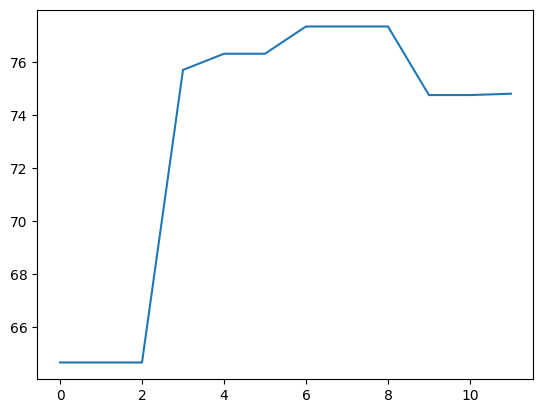

In [19]:
import matplotlib.pyplot as plt

plt.plot(l)
plt.show()